In [146]:
from utils import print_score
from preprocess import preprocess_fraud_data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, f1_score,  precision_recall_curve

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [99]:
ruta = "./data/dataset_balanceado.csv"
df = pd.read_csv(ruta)

data = preprocess_fraud_data(df)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

**Modelo Base de Regresión Logística** 

In [100]:
modelo_base = LogisticRegression(solver='liblinear', random_state=42)
modelo_base.fit(X_train, y_train)

print_score(modelo_base, X_train, y_train, X_val, y_val, train=True)
print_score(modelo_base, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 90.91%
_______________________________________________
CLASSIFICATION REPORT:
                     0      1  accuracy    macro avg  weighted avg
precision     0.909091    0.0  0.909091     0.454545      0.826446
recall        1.000000    0.0  0.909091     0.500000      0.909091
f1-score      0.952381    0.0  0.909091     0.476190      0.865801
support    6000.000000  600.0  0.909091  6600.000000   6600.000000
_______________________________________________
Confusion Matrix: 
 [[6000    0]
 [ 600    0]]

Test Result:
Accuracy Score: 90.91%
_______________________________________________
CLASSIFICATION REPORT:
                     0      1  accuracy    macro avg  weighted avg
precision     0.909091    0.0  0.909091     0.454545      0.826446
recall        1.000000    0.0  0.909091     0.500000      0.909091
f1-score      0.952381    0.0  0.909091     0.476190      0.865801
support    2000.000000  200.0  0.909091  2200.000000   2200.000000
___________________

> - El modelo no es capaz de identificar las transacciones fraudulentas, al tener tan pocos datos de la clase minoritaria `Fraude`, el modelo simplemente predice todas las transacciones como legítimas, debido a  que la mayor cantidad de muestras en los datos que tiene para aprender son de transacciones legítimas, por lo cual decide clasificar el fraude como no fraude. 
>
> - El problema de desbalanceo de clases es tan notable que es necesario aplicar algunos métodos para tratar con clases desbalanceadas, además de que la métrica `accuracy` en estos casos es una métrica engañosa, pues devuelve **90.91%**, lo que podría parecer un resultado bastante bueno cuando en realidad el modelo no predice bien, porque lo que realmente importa es predecir correctamente las transacciones fraudulentas, no las no fraudulentas.
> - En lo adelante hay que prestar más atención a las métricas que tienen más en cuenta a los datos de la clase minoritaria como `F1-score`, `Recall`, `precisión`, `matriz de confusión` , `AUC-ROC`, `PR`.

**Técnicas de Muestreo:**

- **Oversampling** (Sobremuestreo): Consiste en añadir copias de la clase minoritaria para aumentar su peso total.

- **Undersampling** (Submuestreo): Se basa en eliminar muestras de la clase mayoritaria para intentar equilibrar el número de mustras en cada clase.

- **Generación de muestras sintéticas**: En este caso se utilizan algoritmos como `SMOTE` que es capaz de generar más muestras de la clase minoritaria a partir de las que ya se tienen.

- **Uso de pesos en la función de pérdida**: Una estrategia efectiva al entrenar modelos es modificar la función de pérdida asignando pesos mayores a la clase minoritaria, esto incentiva al modelo a prestar más atención a los ejemplos menos representados.

- También se puede utilizar un enfoque híbrido que combina undersampling con oversampling.

**Undersampling Aleatorio**

In [111]:
print("Distribución original:", np.bincount(y_train))

undersampler = RandomUnderSampler(sampling_strategy=1, random_state=42)  # 1:1 ratio
X_under, y_under = undersampler.fit_resample(X_train, y_train)

print("Distribución después de undersampling:", np.bincount(y_under))

model_under = LogisticRegression(solver='liblinear', random_state=42)
model_under.fit(X_under, y_under)

print_score(model_under, X_under, y_under, X_val, y_val, train=True)
print_score(model_under, X_train, y_train, X_val, y_val, train=False)

Distribución original: [6000  600]
Distribución después de undersampling: [600 600]
Train Result:
Accuracy Score: 55.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.549834    0.550167      0.55     0.550001      0.550001
recall       0.551667    0.548333      0.55     0.550000      0.550000
f1-score     0.550749    0.549249      0.55     0.549999      0.549999
support    600.000000  600.000000      0.55  1200.000000   1200.000000
_______________________________________________
Confusion Matrix: 
 [[331 269]
 [271 329]]

Test Result:
Accuracy Score: 48.59%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.917387    0.098361  0.485909     0.507874      0.842930
recall        0.477500    0.570000  0.485909     0.523750      0.485909
f1-score      0.628083    0.167770  0.

> Al eliminar aleatoriamente muestras de la clase mayoritaria (transacciones legítimas), forzamos al modelo a prestar igual atención a ambas clases durante el entrenamiento, lo que provoca que el modelo ya sea capaz de detectar el fraude, además el `recall` para la clase 1 sube de 0 a **0.57**, lo que significa que el modelo esta identificando al 57% de los fraudes reales.
>
> Sin embargo, con esta técnica la `precisión` para la clase fraude es muy baja (**0.098**), lo que indica que se genera una gran cantidad de falsas alarmas (`Falsos Positivos`), de cada 100 alertas de fraude, más de 90 son incorrectas, además, al eliminar tantos datos de transacciones legítimas, el modelo pierde contexto y su rendimiento general se afecta como se ve en el alto número de falsos positivos (1045).
>
> El undersampling es efectivo para que el modelo comience a detectar la clase minoritaria, pero es una estrategia que sacrifica demasiada precisión, y el objetivo es detectar todos los fraudes pero también generar la menor cantidad de falsas alarmas posibles.

**Oversampling Aleatorio**

In [112]:
#print("Distribución original:", np.bincount(y_train))

oversampler = RandomOverSampler(sampling_strategy=1, random_state=42)
X_over, y_over = oversampler.fit_resample(X_train, y_train)

#print("Distribución después de undersampling:", np.bincount(y_over))

model_over = LogisticRegression(solver='liblinear', random_state=42)
model_over.fit(X_over, y_over)

print_score(model_over, X_over, y_over, X_val, y_val, train=True)
print_score(model_over, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 53.37%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.533937     0.533565   0.53375      0.533751      0.533751
recall        0.531000     0.536500   0.53375      0.533750      0.533750
f1-score      0.532464     0.535029   0.53375      0.533746      0.533746
support    6000.000000  6000.000000   0.53375  12000.000000  12000.000000
_______________________________________________
Confusion Matrix: 
 [[3186 2814]
 [2781 3219]]

Test Result:
Accuracy Score: 50.32%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.907457    0.089236  0.503182     0.498347      0.833074
recall        0.505000    0.485000  0.503182     0.495000      0.503182
f1-score      0.648892    0.150738  0.503182     0.399815      0.603605
support    2000.000000  200.000

> En lugar de eliminar datos, en este caso duplicamos las muestras de la clase fraude para igualar en número a la clase no fraude, el resultado es similar al undersampling en cuanto a que el modelo aprende a detectar fraudes, pero con un rendimiento ligeramente inferior en este caso. Se obtiene un `recall` de **0.485**, lo que significa que detectamos casi la mitad de los fraudes.
>
> La `precisión` sigue siendo un gran problema (**0.089**), muy similar al undersampling, lo que confirma que simplemente balancear las clases 1:1 genera muchas falsas alarmas. El principal inconveniente del oversampling simple es el **sobreajuste (overfitting)**, al duplicar exactamente las mismas muestras, el modelo puede memorizar patrones específicos de esos fraudes en lugar de aprender características generales, lo que limita su capacidad de generalización a nuevos datos.
>
> El oversampling también resuelve el problema de que el modelo ya sea capaz de detectar las transacciones fraudulentas, pero al igual que el undersampling, tiene una precisión muy baja y puede llevar a un sobreajuste.

**SMOTE (Generar muestras sintéticas)**

In [103]:
smote = SMOTE(sampling_strategy=1, random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

model_smote = LogisticRegression(solver='liblinear', random_state=42)
model_smote.fit(X_smote, y_smote)

print_score(model_smote, X_smote, y_smote, X_val, y_val, train=True)
print_score(model_smote, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 63.04%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.616983     0.647336  0.630417      0.632159      0.632159
recall        0.687833     0.573000  0.630417      0.630417      0.630417
f1-score      0.650485     0.607904  0.630417      0.629194      0.629194
support    6000.000000  6000.000000  0.630417  12000.000000  12000.000000
_______________________________________________
Confusion Matrix: 
 [[4127 1873]
 [2562 3438]]

Test Result:
Accuracy Score: 64.14%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.908294    0.089261  0.641364     0.498777      0.833836
recall        0.673500    0.320000  0.641364     0.496750      0.641364
f1-score      0.773471    0.139586  0.641364     0.456528      0.715845
support    2000.000000  200.000

> SMOTE es una técnica de oversampling más inteligente, en lugar de duplicar, crea muestras sintéticas plausibles, esto debería ayudar al modelo a generalizar mejor. Sin embargo, en los resultados obtenidos, SMOTE obtiene el `recall` más bajo de las técnicas de remuestreo hasta ahora (**0.32**) y una `precisión` igualmente baja (**0.089**).
>
> Esto podría pasar porque SMOTE al crear nuevas muestras, puede estar generando `ruido`, si crea puntos sintéticos en áreas donde las clases se solapan mucho, puede hacer que la frontera de decisión sea más confusa para un modelo lineal como la Regresión Logística. La matriz de confusión muestra un número muy alto de falsos positivos (653), lo que fundamenta esta idea.
>
> Aunque la técnica SMOTE teóricamente es superior a las demás, en este caso por sí solo no ha superado a las técnicas de muestreo aleatorio, esto sugiere que la limpieza de la frontera de decisión es crucial.

**Parámetro: `class_weight='balanced'`**

Al agregra este parámetro el algoritmo automáticamente ajustará los pesos de manera inversamente proporcional a las frecuencias de las clases, es decir, le dará un peso mucho mayor a la clase de fraude.

In [104]:
model_balanced = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',  #Ajusta pesos automáticamente
    random_state=42
)

model_balanced.fit(X_train, y_train) 

print_score(model_balanced, X_train, y_train, X_val, y_val, train=True)
print_score(model_balanced, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 52.14%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.918409    0.100780  0.521364     0.509595      0.844079
recall        0.519667    0.538333  0.521364     0.529000      0.521364
f1-score      0.663757    0.169777  0.521364     0.416767      0.618850
support    6000.000000  600.000000  0.521364  6600.000000   6600.000000
_______________________________________________
Confusion Matrix: 
 [[3118 2882]
 [ 277  323]]

Test Result:
Accuracy Score: 50.50%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.909991    0.091827     0.505     0.500909      0.835612
recall        0.505500    0.500000     0.505     0.502750      0.505000
f1-score      0.649952    0.155159     0.505     0.402555      0.604971
support    2000.000000  200.000000     0.

> Se ajusta la función de coste del modelo para que penalice mucho más los errores en la clase minoritaria (fraude). Los resultados son muy competitivos: obtenemos un `recall` de **0.50**, detectando la mitad de los fraudes. La `precisión` sigue siendo baja (**0.091**)
>
> La ventaja de esta técnica es que no requiere crear ni eliminar datos, lo que evita el riesgo de sobreajuste por duplicación o la pérdida de información por eliminación.
>
> `class_weight='balanced'` proporciona un buen equilibrio entre la capacidad de detección y la simplicidad, logrando resultados comparables a técnicas de remuestreo más complejas.

**SMOTETomek:** Técnica híbrida que combina oversampling (SMOTE) con undersampling (Tomek Links).

El proceso es el siguiente:

- **Oversampling** (SMOTE): Primero, se aplica SMOTE al conjunto de datos de entrenamiento, esto crea nuevas muestras sintéticas de la clase minoritaria (fraude) hasta alcanzar un cierto balance (generalmente 1:1, pero se puede configurar).

- **Undersampling** (Tomek Links): Después de generar los nuevos puntos de fraude, se aplica Tomek Links, un "Tomek Link" es un par de puntos de clases opuestas que son los vecinos más cercanos el uno del otro, en este paso, se eliminan las muestras de la clase mayoritaria que forman parte de un Tomek Link, en otras palabras, elimina las instancias de la clase mayoritaria que están demasiado cerca de las minoritarias, limpiando el ruido creado por SMOTE.

SMOTE puede generar puntos sintéticos en regiones `ruidosas`, muy cerca de la frontera de decisión o incluso dentro del territorio de la clase mayoritaria. Al aplicar Tomek Links después, se `limpia` la frontera de decisión, eliminando puntos de la clase mayoritaria que están demasiado cerca de los puntos de la clase minoritaria (tanto los originales como los sintéticos). Esto ayuda a que el modelo aprenda una separación entre clases más clara y a menudo mejora la precisión sin sacrificar mucho el recall.

In [113]:
#Por defecto, SMOTE intentará balancear a 1:1
smt_tomek = SMOTETomek(random_state=42)

#print("Distribución original en entrenamiento:", np.bincount(y_train))

X_train_resampled, y_train_resampled = smt_tomek.fit_resample(X_train, y_train)

#print("Distribución después de SMOTETomek:", np.bincount(y_train_resampled))

model_smotetomek = LogisticRegression(solver='liblinear', random_state=42)
model_smotetomek.fit(X_train_resampled, y_train_resampled)

print_score(model_smotetomek, X_train_resampled, y_train_resampled, X_val, y_val, train=True)
print_score(model_smotetomek, X_train, y_train, X_val, y_val, train=False)


Train Result:
Accuracy Score: 63.08%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.617158     0.648061  0.630809      0.632609      0.632609
recall        0.689067     0.572551  0.630809      0.630809      0.630809
f1-score      0.651133     0.607970  0.630809      0.629552      0.629552
support    5982.000000  5982.000000  0.630809  11964.000000  11964.000000
_______________________________________________
Confusion Matrix: 
 [[4122 1860]
 [2557 3425]]

Test Result:
Accuracy Score: 64.14%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.908294    0.089261  0.641364     0.498777      0.833836
recall        0.673500    0.320000  0.641364     0.496750      0.641364
f1-score      0.773471    0.139586  0.641364     0.456528      0.715845
support    2000.000000  200.000

> Esta técnica híbrida primero usa SMOTE para generar muestras de fraude y luego usa Tomek Links para limpiar la frontera, eliminando muestras de la clase mayoritaria que están demasiado cerca de las de fraude, el `recall` es de **0.32**, idéntico al de SMOTE solo, pero la `precisión` (**0.089**) y el `F1-score` (**0.139**) tampoco mejoran en este caso.
>
> El rendimiento es idéntico al de SMOTE, lo que podría indicar que en el conjunto de datos Tomek Links no encontró muchos pares para eliminar después de la aplicación de SMOTE, o que las eliminaciones no afectaron significativamente la frontera de decisión que aprende la Regresión Logística.
>
> La implementación de SMOTETomek no ha supuesto una mejora sobre SMOTE en este escenario particular, el problema de la baja precisión persiste.

##### **Selección del Mejor Modelo:**

Para elegir el mejor enfoque se realiza la comparación de las métricas obtenidas en el conjunto de validación, dándole prioridad a la **F1-Score**, ya que representa un balance entre `recall` y `precision`, y en el `recall` ya que se quiere detectar todos los fraudes posibles.

| Técnica de Muestreo | Recall (Fraude) | Precision (Fraude) | F1-Score (Fraude) |
| :--- | :---: | :---: | :---: |
| Modelo Base | 0.00 | 0.00 | 0.00 |
| **Random Undersampling** | **0.570** | **0.098** | **0.167** |
| Random Oversampling | 0.485 | 0.089 | 0.150 |
| SMOTE | 0.320 | 0.089 | 0.139 |
| `class_weight='balanced'` | 0.500 | 0.091 | 0.155 |
| SMOTETomek | 0.320 | 0.089 | 0.139 |

**Resultados:**

- El modelo con `RandomUnderSampler` es el mejor hasta ahora identificando un 57% de los fraudes y también obtiene el F1-Score más alto (0.167), indicando el mejor equilibrio general (aunque aún es muy bajo) entre recall y precision.
- El modelo con `class_weight='balanced'` ofrece un rendimiento muy cercano (Recall 0.50, F1-score 0.155).

Aunque `RandomUnderSampler` tiene los mejores resultados en el enfoque del problema, su principal desventaja es que se elimina una gran cantidad de datos que podrían ser útiles, además genera demasiados falsos positivos, por lo que el objetivo será intentar mejorar su  precisión mediante el ajuste de hiperparámetros.

**Ajuste de hiperpárametros**

In [151]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

#El pipeline asegura que el undersampling se aplique correctamente en cada paso de la validación cruzada.
pipeline = Pipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(solver='liblinear', random_state=42))
])

#Rango de valores para 'C' para probar. (se usa una escala logarítmica)
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

#Se busca que el modelo maximice el F1-score de la clase positiva.
grid_search = GridSearchCV(estimator=pipeline, 
                            param_grid=param_grid, 
                            scoring='f1',
                            cv=5, 
                            n_jobs=-1,
                            verbose=1)

print("Iniciando ajuste de hiperparámetros con GridSearchCV...")
grid_search.fit(X_train, y_train)

print("\n--- Búsqueda con GridSearchCV Finalizada ---")
print(f"Mejor F1-score durante la validación cruzada: {grid_search.best_score_:.4f}")
print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")

best_model_tuned = grid_search.best_estimator_

Iniciando ajuste de hiperparámetros con GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Búsqueda con GridSearchCV Finalizada ---
Mejor F1-score durante la validación cruzada: 0.1506
Mejores hiperparámetros encontrados: {'model__C': 0.01}


In [ ]:
y_pred_val = best_model_tuned.predict(X_val)  
print(classification_report(y_val, y_pred_val))
print("Matriz de Confusión en Validación:")
print(confusion_matrix(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.92      0.48      0.63      2000
           1       0.10      0.56      0.17       200

    accuracy                           0.49      2200
   macro avg       0.51      0.52      0.40      2200
weighted avg       0.84      0.49      0.59      2200

Matriz de Confusión en Validación:
[[ 963 1037]
 [  87  113]]


**Ajuste del umbral para maximizar `F1-score`**

El mejor F1-Score en el conjunto de validación es: nan
Este F1-Score se alcanza con un umbral de: 0.5761


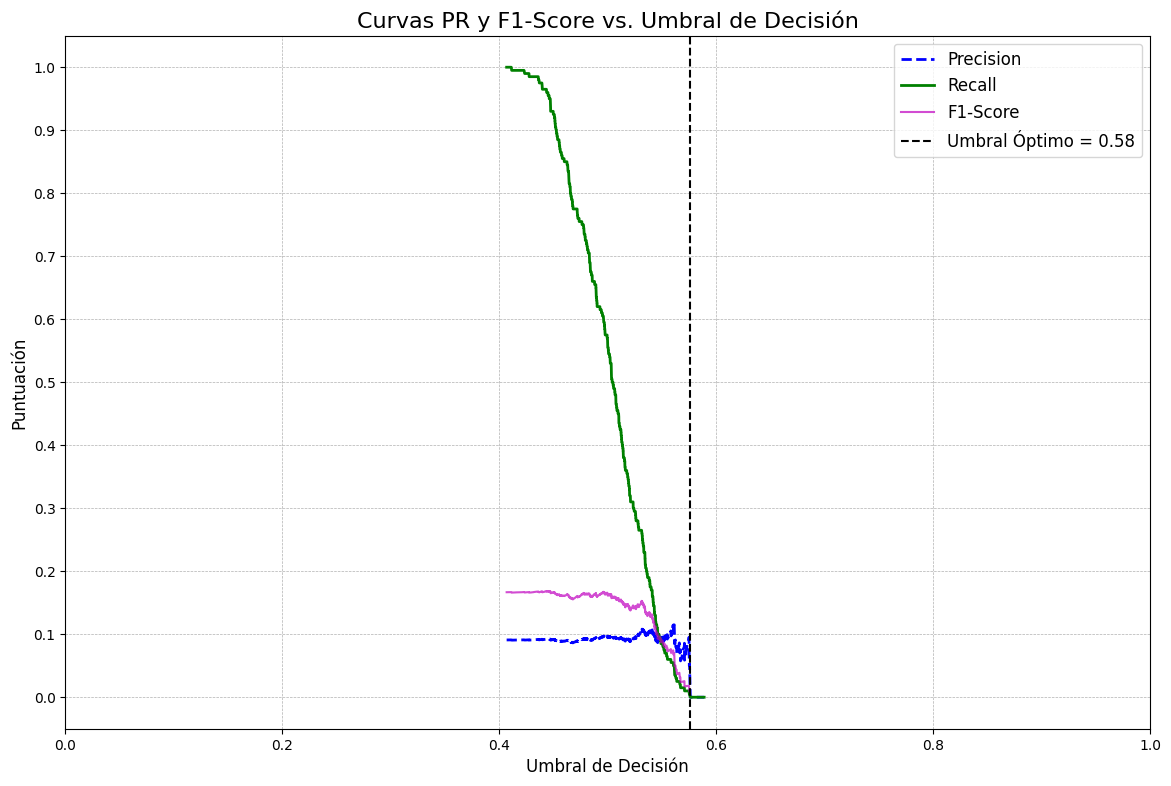

In [153]:
from sklearn.metrics import precision_recall_curve

y_probs_val = best_model_tuned.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_probs_val)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_f1_idx = np.argmax(f1_scores)

umbral_optimo = thresholds[best_f1_idx]
mejor_f1_score = f1_scores[best_f1_idx]

print(f"El mejor F1-Score en el conjunto de validación es: {mejor_f1_score:.4f}")
print(f"Este F1-Score se alcanza con un umbral de: {umbral_optimo:.4f}")

plt.figure(figsize=(14, 9))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], 'g-', label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores[:-1], 'm-', label='F1-Score', linewidth=1.5, alpha=0.7)

plt.axvline(x=umbral_optimo, color='black', linestyle='--', 
            label=f'Umbral Óptimo = {umbral_optimo:.2f}')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim([0.0, 1.0])
plt.title('Curvas PR y F1-Score vs. Umbral de Decisión', fontsize=16)
plt.xlabel('Umbral de Decisión', fontsize=12)
plt.ylabel('Puntuación', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [154]:
#Evaluar con el umbral óptimo
y_pred_umbral_optimo = (y_probs_val >= umbral_optimo).astype(int)

print(f"\n--- Resultados en Validación con el umbral óptimo de {umbral_optimo:.4f} ---")
print(classification_report(y_val, y_pred_umbral_optimo))
print(f"Matriz de Confusión en Validación (umbral = {umbral_optimo:.4f}):")
print(confusion_matrix(y_val, y_pred_umbral_optimo))


--- Resultados en Validación con el umbral óptimo de 0.5761 ---
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2000
           1       0.00      0.00      0.00       200

    accuracy                           0.90      2200
   macro avg       0.45      0.50      0.47      2200
weighted avg       0.83      0.90      0.86      2200

Matriz de Confusión en Validación (umbral = 0.5761):
[[1982   18]
 [ 200    0]]


In [ ]:
y_probs_test = best_model_tuned.predict_proba(X_test)[:, 1]

y_pred_final = (y_probs_test >= umbral_optimo).astype(int)

print(f"Umbral de decisión ajustado (óptimo según F1-Score): {umbral_optimo:.4f}\n")
print(classification_report(y_test, y_pred_final))
print(f"Matriz de Confusión en Prueba:")
print(confusion_matrix(y_test, y_pred_final))

Umbral de decisión ajustado (óptimo según F1-Score): 0.5761

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2000
           1       0.07      0.07      0.07       200

    accuracy                           0.83      2200
   macro avg       0.49      0.49      0.49      2200
weighted avg       0.83      0.83      0.83      2200

Matriz de Confusión en Prueba:
[[1819  181]
 [ 186   14]]


**Ajustar hiperpárametros en el modelo `class_weight='balanced'`**

In [ ]:
model_weighted = LogisticRegression(solver='liblinear', 
                                    random_state=42, 
                                    class_weight='balanced')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search_weighted = GridSearchCV(estimator=model_weighted,
                                    param_grid=param_grid,
                                    scoring='f1',
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=1)


grid_search_weighted.fit(X_train, y_train)

print(f"Mejor F1-score durante la validación cruzada: {grid_search_weighted.best_score_:.4f}")
print(f"Mejores hiperparámetros encontrados: {grid_search_weighted.best_params_}")

best_model_weighted = grid_search_weighted.best_estimator_

print("\n--- Reporte del Modelo con class_weight en Validación (umbral 0.5) ---")
y_pred_val_weighted = best_model_weighted.predict(X_val)
print(classification_report(y_val, y_pred_val_weighted))
print("Matriz de Confusión en Validación:")
print(confusion_matrix(y_val, y_pred_val_weighted))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor F1-score durante la validación cruzada: 0.1467
Mejores hiperparámetros encontrados: {'C': 0.01}

--- Reporte del Modelo con class_weight en Validación (umbral 0.5) ---
              precision    recall  f1-score   support

           0       0.91      0.50      0.65      2000
           1       0.09      0.50      0.15       200

    accuracy                           0.50      2200
   macro avg       0.50      0.50      0.40      2200
weighted avg       0.83      0.50      0.60      2200

Matriz de Confusión en Validación:
[[1001  999]
 [ 100  100]]


El mejor F1-Score en el conjunto de validación es: 0.1682
Este F1-Score se alcanza con un umbral de: 0.4790


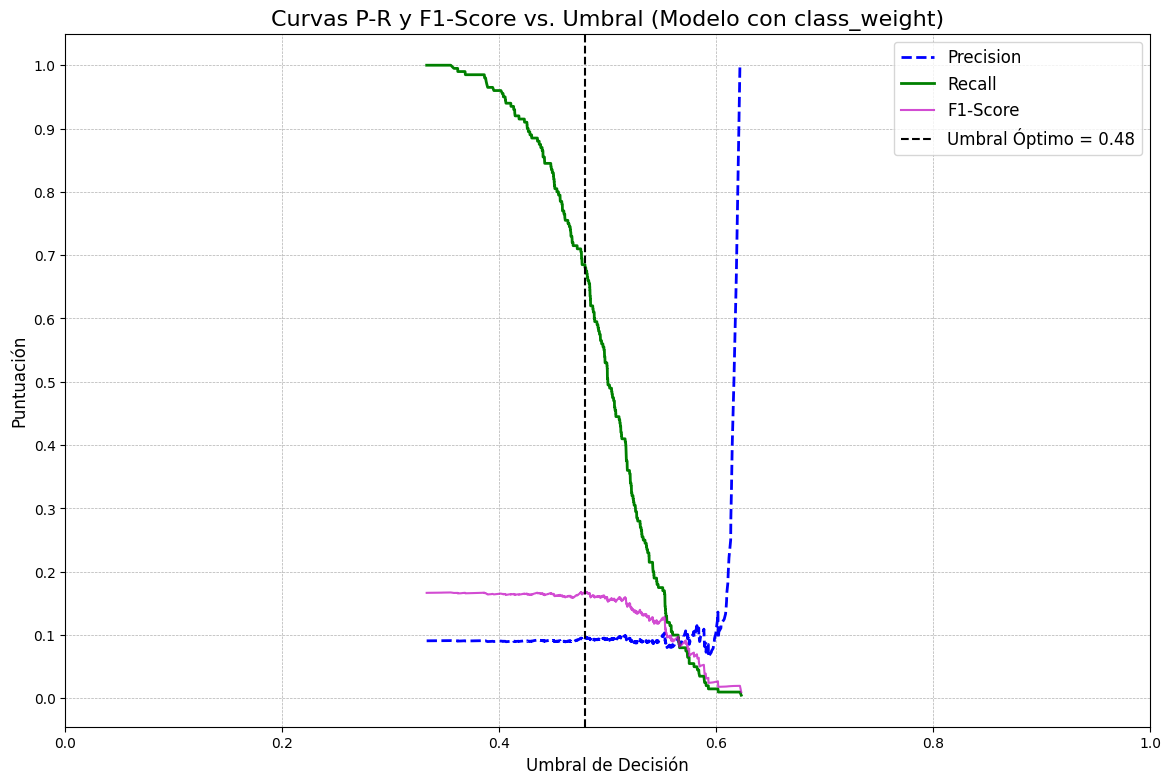

In [ ]:
y_probs_val_weighted = best_model_weighted.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_probs_val_weighted)

f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)

best_f1_idx = np.argmax(f1_scores)

umbral_optimo_weighted = thresholds[best_f1_idx]
mejor_f1_score = f1_scores[best_f1_idx]

print(f"El mejor F1-Score en el conjunto de validación es: {mejor_f1_score:.4f}")
print(f"Este F1-Score se alcanza con un umbral de: {umbral_optimo_weighted:.4f}")

plt.figure(figsize=(14, 9))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], 'g-', label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores[:-1], 'm-', label='F1-Score', linewidth=1.5, alpha=0.7)

plt.axvline(x=umbral_optimo_weighted, color='black', linestyle='--', 
            label=f'Umbral Óptimo = {umbral_optimo_weighted:.2f}')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim([0.0, 1.0])
plt.title('Curvas P-R y F1-Score vs. Umbral (Modelo con class_weight)', fontsize=16)
plt.xlabel('Umbral de Decisión', fontsize=12)
plt.ylabel('Puntuación', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [162]:
y_pred_umbral_optimo = (y_probs_val_weighted >= umbral_optimo_weighted).astype(int)

print(f"\n--- Resultados en Validación con umbral óptimo de {umbral_optimo_weighted:.4f} ---")
print(classification_report(y_val, y_pred_umbral_optimo))
print(f"Matriz de Confusión en Validación (umbral = {umbral_optimo_weighted:.4f}):")
print(confusion_matrix(y_val, y_pred_umbral_optimo))


--- Resultados en Validación con umbral óptimo de 0.4790 ---
              precision    recall  f1-score   support

           0       0.92      0.35      0.51      2000
           1       0.10      0.69      0.17       200

    accuracy                           0.38      2200
   macro avg       0.51      0.52      0.34      2200
weighted avg       0.84      0.38      0.48      2200

Matriz de Confusión en Validación (umbral = 0.4790):
[[ 708 1292]
 [  63  137]]


In [ ]:
y_probs_test_weighted = best_model_weighted.predict_proba(X_test)[:, 1]

y_pred_final_weighted = (y_probs_test_weighted >= umbral_optimo_weighted).astype(int)





print(f"Hiperparámetro C óptimo: {grid_search_weighted.best_params_['C']}")
print(f"Umbral de decisión ajustado (óptimo según F1-Score): {umbral_optimo_weighted:.4f}\n")

print(classification_report(y_test, y_pred_final_weighted))
print("Matriz de Confusión en Prueba:")
print(confusion_matrix(y_test, y_pred_final_weighted))

Hiperparámetro C óptimo: 0.01
Umbral de decisión ajustado (óptimo según F1-Score): 0.4790

              precision    recall  f1-score   support

           0       0.91      0.37      0.53      2000
           1       0.09      0.66      0.16       200

    accuracy                           0.40      2200
   macro avg       0.50      0.51      0.35      2200
weighted avg       0.84      0.40      0.49      2200

Matriz de Confusión en Prueba:
[[ 741 1259]
 [  69  131]]


> La Regresión Logística, al ser un modelo lineal, ha mostrado sus limitaciones para capturar los patrones complejos y no lineales que probablemente caracterizan a las transacciones fraudulentas. A pesar de aplicar técnicas avanzadas para el desbalanceo de clases como el ajuste de pesos y la optimización de umbrales, y lograr un buen Recall (66%), no se ha conseguido una Precisión aceptable.
>
>El modelo final de Regresión Logística con class_weight='balanced' y umbral optimizado es el mejor resultado de esta etapa, pero su alto volumen de falsas alarmas lo hace inviable para una implementación en un entorno real.